In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import re

df = pd.read_csv("2025_Airbnb_NYC_listings.csv")
df

,Unnamed: 0,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,36121,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,62165,Michael,2009-12-11,"New York, NY",...,5.00,5.00,5.00,NaN,f,1,0,1,0,0.05
1,1,36647,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",157798,Irene,2010-07-04,"New York, NY",...,4.90,4.38,4.71,NaN,f,1,0,1,0,0.58
2,2,38663,city scrape,Luxury Brownstone in Boerum Hill,"Beautiful, large home in great hipster neighbo...","diverse, lively, hip, cool: loaded with restau...",165789,Sarah,2010-07-13,"New York, NY",...,4.88,4.86,4.62,OSE-STRREG-0001784,f,1,0,1,0,0.28
3,3,38833,city scrape,Spectacular West Harlem Garden Apt,This is a very large and unique space. An inc...,West Harlem is now packed with great restauran...,166532,Matthew,2010-07-14,"New York, NY",...,4.96,4.79,4.82,OSE-STRREG-0000476,f,1,1,0,0,1.36
4,4,39282,city scrape,“Work-from-home” from OUR home.,*Monthly Discount will automatically apply <br...,THE NEIGHBORHOOD:<br />Our apartment is locate...,168525,Gustavo,2010-07-16,"New York, NY",...,4.88,4.85,4.78,OSE-STRREG-0001150,f,2,0,2,0,1.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22303,37429,1366333532374850165,city scrape,Beautiful 1-Bed Apt in Harlem!,Welcome to your temporary home in the vibrant ...,NaN,40019013,Cecilia,2015-07-30,"New York, NY",...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
22304,37430,1366717321390111215,city scrape,Private Room w/ Ensuite Bath H,Stylish Private Rooms w/ En-Suite Baths in Bro...,NaN,483056418,Kristina,2022-10-10,"New York, NY",...,NaN,NaN,NaN,NaN,f,24,0,24,0,NaN
22305,37431,1366721904709517353,city scrape,2 Bedroom on East Side,Located in the Murray Hill area and occupies a...,NaN,30283594,Global Luxury Suites,2015-03-30,"Hawthorne, NJ",...,NaN,NaN,NaN,NaN,f,48,48,0,0,NaN
22306,37432,1366722692755341871,city scrape,Stylish 2Bd near Bryant Park,Enjoy everything the city has to offer while l...,NaN,407304997,Boomerang,2021-06-15,"New York, NY",...,NaN,NaN,NaN,NaN,t,25,25,0,0,NaN


In [3]:
# 전처리 1 - id int로 변경
df['id'] = df['id'].astype(int)

# booking_info
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['instant_bookable'] =  df['instant_bookable'].map({'f':0, 't':1})
df['is_long_term'] = (df['minimum_nights'] >= 28).astype(int)

# amenities_info
def parse_amenities(x):
    try:
        return [a.strip().strip('"').strip("'") for a in ast.literal_eval(x)]
    except:
        return []
    
df['amenities'] = df['amenities'].apply(parse_amenities)
df['amenities_cnt'] = df['amenities'].apply(len)

# host_info
# neighborhood_overview 결측치 많아서 유무대체 
df['neighborhood_overview_exists'] = df['neighborhood_overview'].notnull().astype(int)

# name 글자수기준 중앙값으로 그룹
df['name_length'] = df['name'].fillna('').astype(str).apply(len)
med_length = df['name_length'].median()

def name_length_group(length, med):
    if length == 0:
        return 'empty'
    elif length > med:
        return 'long'
    else:
        return 'short_or_med'
    
df['name_length_group'] = df['name_length'].apply(lambda x: name_length_group(x, med_length))

# description 글자수기준(결측치 405) 평균으로 그룹
df['description_length'] = df['description'].fillna('').astype(str).apply(len)
avg_length = df['description_length'].mean()

def name_length_group(length, avg):
    if length == 0:
        return 'empty'
    elif length > avg:
        return 'long'
    else:
        return 'short_or_avg'
    
df['description_length_group'] = df['description_length'].apply(lambda x: name_length_group(x, avg_length))

# host_about (결측치8917) 평균(243) 중앙값(81) 중앙값기준으로 그룹
df['host_about_length'] = df['host_about'].fillna('').astype(str).apply(len)
med_length = df['host_about_length'].median()

def name_length_group(length, med):
    if length == 0:
        return 'empty'
    elif length > med:
        return 'long'
    else:
        return 'short_or_med'
df['host_about_length_group'] = df['host_about_length'].apply(lambda x: name_length_group(x, med_length))


#host_identity_verified/host_has_profile_pic /host_is_superhost  
# True / Flase 1과 0으로 대체 (결측치 20/20/350 0으로 대체함)
df['host_identity_verified']=df['host_identity_verified'].fillna('f').map({'t': 1, 'f': 0}).astype(int)

df['host_has_profile_pic']=df['host_has_profile_pic'].fillna('f').map({'t': 1, 'f': 0}).astype(int)

df['host_is_superhost']=df['host_is_superhost'].fillna('f').map({'t': 1, 'f': 0}).astype(int)

# host_response_time 결측치는 중앙값으로 치환후 점수
response_time_score_map = { 
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1
}
df['host_response_time_score'] = df['host_response_time'].map(response_time_score_map)

# 2. response_time_score 컬럼의 중앙값 계산
med_score_for_fillna = df['host_response_time_score'].median()

# 3. response_time_score 컬럼의 NaN을 계산된 중앙값으로 대체 
df['host_response_time_score'] = df['host_response_time_score'].fillna(med_score_for_fillna)

# host_response_time 칼럼에는 여전히 nan값 존재함
# response_time_score 칼럼만 중앙값대체 


# host_response_rate 컬럼 %제외하고 중앙값으로 대체
df['host_response_rate'] = df['host_response_rate'].astype(str).str.replace('%', '').astype(float)/100
med_rate2 = df['host_response_rate'].median()
df['host_response_rate']= df['host_response_rate'].fillna(med_rate2)

# 4그룹으로 나눠 점수
conditions = [
    (df['host_response_rate'] <= 0.25),
    (df['host_response_rate'] > 0.25) & (df['host_response_rate'] <= 0.5),
    (df['host_response_rate'] > 0.5) & (df['host_response_rate'] <= 0.75),
    (df['host_response_rate'] > 0.75)
]

choices = [1, 2, 3, 4]

df['host_response_rate_score'] = np.select(conditions, choices)


# host_acceptance_rate 칼럼도 %제외하고 중앙값으로 대체 
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(str).str.replace('%', '').astype(float)/100
med_rate = df['host_acceptance_rate'].median()
df['host_acceptance_rate']= df['host_acceptance_rate'].fillna(med_rate)

conditions = [
    (df['host_acceptance_rate'] <= 0.25),
    (df['host_acceptance_rate'] > 0.25) & (df['host_acceptance_rate'] <= 0.5),
    (df['host_acceptance_rate'] > 0.5) & (df['host_acceptance_rate'] <= 0.75),
    (df['host_acceptance_rate'] > 0.75)
]

choices = [1, 2, 3, 4]

df['host_acceptance_rate_score'] = np.select(conditions, choices)

# host_location 칼럼 
# host_loc 존재?
df['host_location_boolean'] = df['host_location'].notnull().astype(int)
# host_loc in NY?
df['host_location_ny'] = df['host_location'].str.contains('New York', na=False).astype(int)



#rooms_info
# --- Personal preprocessing code ---
# Convert "beds" from float to int
# Replace missing or non-bed values with median (assumed 1)
df['beds'] = df['beds'].fillna(0).astype(int)
df['beds'] = df['beds'].replace(0, 1)

# Clean up "bathrooms", "bathrooms_text" column:
# - Replace invalid or missing values with median (assumed 1)
df['bathrooms'] = df['bathrooms'].fillna(0)

def parse_baths(text):
    if pd.isna(text):
        return np.nan
    s = str(text).lower()
    m = re.search(r'(\d+(\.\d+)?)', s)
    if m:
        return float(m.group(1))
    if 'half' in s:
        return 0.5
    return np.nan

df['bathrooms_parsed'] = df['bathrooms_text'].apply(parse_baths)
mask_mismatch = df['bathrooms_parsed'].notna() & (df['bathrooms'] != df['bathrooms_parsed'])
df.loc[mask_mismatch, 'bathrooms'] = df.loc[mask_mismatch, 'bathrooms_parsed']
df = df.drop(columns=['bathrooms_parsed'])

df['bathrooms_text'] = df['bathrooms_text'].fillna(0)

df['is_shared'] = df['bathrooms_text'] \
    .str.contains('shared', case=False, na=False)

df['is_private'] = ~df['is_shared']

w_private = 1.0   # 전용 욕실 가중치
w_shared  = 0.5   # 공용 욕실 가중치

df['bath_score_mul'] = (
    df['bathrooms'] * np.where(df['is_private'], w_private, w_shared)
)

df['bathrooms'] = df['bathrooms'].replace(0.00, 1)
df['bath_score_mul'] = df['bath_score_mul'].replace(0.00, 1)

# Clean up "room_type", "property_type" column:
#
def extract_structure(pt):
    pt_l = pt.strip().lower()
    if ' in ' in pt_l:
        return pt_l.split(' in ',1)[1].strip()
    if pt_l.startswith('entire '):
        return pt_l.replace('entire ','').strip()
    if pt_l.startswith('private room'):
        return pt_l.replace('private room','').strip()
    if pt_l.startswith('shared room'):
        return pt_l.replace('shared room','').strip()
    return pt_l

rt_cats = set(df['room_type'].str.strip().str.lower())
df['structure_type'] = df['property_type'].apply(lambda x: (
    x.strip().lower() if x.strip().lower() not in rt_cats
    else pd.NA
))

mask = df['structure_type'].notna()
df.loc[mask, 'structure_type'] = df.loc[mask, 'structure_type'].apply(extract_structure)

residential = {
    'rental unit','home','condo','townhouse','cottage',
    'bungalow','villa','vacation home','earthen home',
    'ranch','casa particular','tiny home','entire home/apt'
}
apartment_suite = {
    'guest suite','loft','serviced apartment','aparthotel',
    'private room'
}
hotel_lodging = {
    'hotel','boutique hotel','bed and breakfast',
    'resort','hostel','guesthouse','hotel room'
}

def map_category(row):
    pt = row['property_type'].strip().lower()
    rt = row['room_type'].strip().lower()
    st = row['structure_type']
    if rt in residential or pt in residential or (isinstance(st, str) and st in residential):
        return 'Residential'
    elif rt in apartment_suite or pt in apartment_suite or (isinstance(st, str) and st in apartment_suite):
        return 'Apartment_Suite'
    elif rt in hotel_lodging or pt in hotel_lodging or (isinstance(st, str) and st in hotel_lodging):
        return 'Hotel_Lodging'
    else:
        return 'Others'

df['structure_category'] = df.apply(map_category, axis=1)


for col in [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value'
]:
    df[col].fillna(df[col].mean(), inplace=True)
    df[col] = df[col].round(2)



<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\$'
C:\Users\HY\AppData\Local\Temp\ipykernel_13552\1019980279.py:5: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\HY\AppData\Local\Temp\ipykernel_13552\1019980279.py:236: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


In [4]:
loc_cols_filter = ['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude']
booking_cols_filter = ['price', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'availability_60', 'availability_365', 'instant_bookable', 'is_long_term']
amenities_cols = ['amenities', 'amenities_cnt']
room_cols_filter = ['room_type', 'structure_type', 'structure_category','accommodates', 'bath_score_mul', 'beds']
reviews_cols_filter =  ['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
host_cols_filter = ['id','host_id','name_length_group','description_length_group','neighborhood_overview_exists','host_about_length_group','host_is_superhost',
    'host_has_profile_pic','host_identity_verified','host_response_time_score','host_response_rate_score','host_acceptance_rate_score','host_location_ny','host_location_boolean']

df_list = loc_cols_filter + booking_cols_filter + amenities_cols + room_cols_filter + host_cols_filter + reviews_cols_filter

In [5]:
df = df[df_list]
df

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,...,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,Prospect Heights,Brooklyn,40.673760,-73.966110,200.0,0,0.0,57,362,0,...,9,0,0,4.88,5.00,4.80,5.00,5.00,5.00,5.00
1,East Harlem,Manhattan,40.792454,-73.940742,82.0,0,0.0,0,204,0,...,102,0,0,4.77,4.82,4.76,4.88,4.90,4.38,4.71
2,Boerum Hill,Brooklyn,40.684420,-73.980680,765.0,0,0.0,49,326,0,...,43,0,0,4.70,4.83,4.52,4.88,4.88,4.86,4.62
3,Harlem,Manhattan,40.818058,-73.946671,139.0,255,35445.0,18,25,0,...,241,42,3,4.85,4.87,4.50,4.96,4.96,4.79,4.82
4,Williamsburg,Brooklyn,40.710651,-73.950874,130.0,154,20020.0,22,38,0,...,274,12,0,4.82,4.83,4.61,4.94,4.88,4.85,4.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22303,Harlem,Manhattan,40.813794,-73.952399,72.0,0,0.0,53,358,0,...,0,0,0,4.72,4.75,4.69,4.83,4.81,4.73,4.61
22304,Bedford-Stuyvesant,Brooklyn,40.685500,-73.919510,58.0,0,0.0,58,363,0,...,0,0,0,4.72,4.75,4.69,4.83,4.81,4.73,4.61
22305,Kips Bay,Manhattan,40.745290,-73.979380,299.0,0,0.0,39,99,0,...,0,0,0,4.72,4.75,4.69,4.83,4.81,4.73,4.61
22306,Theater District,Manhattan,40.757133,-73.983124,200.0,0,0.0,60,365,1,...,0,0,0,4.72,4.75,4.69,4.83,4.81,4.73,4.61


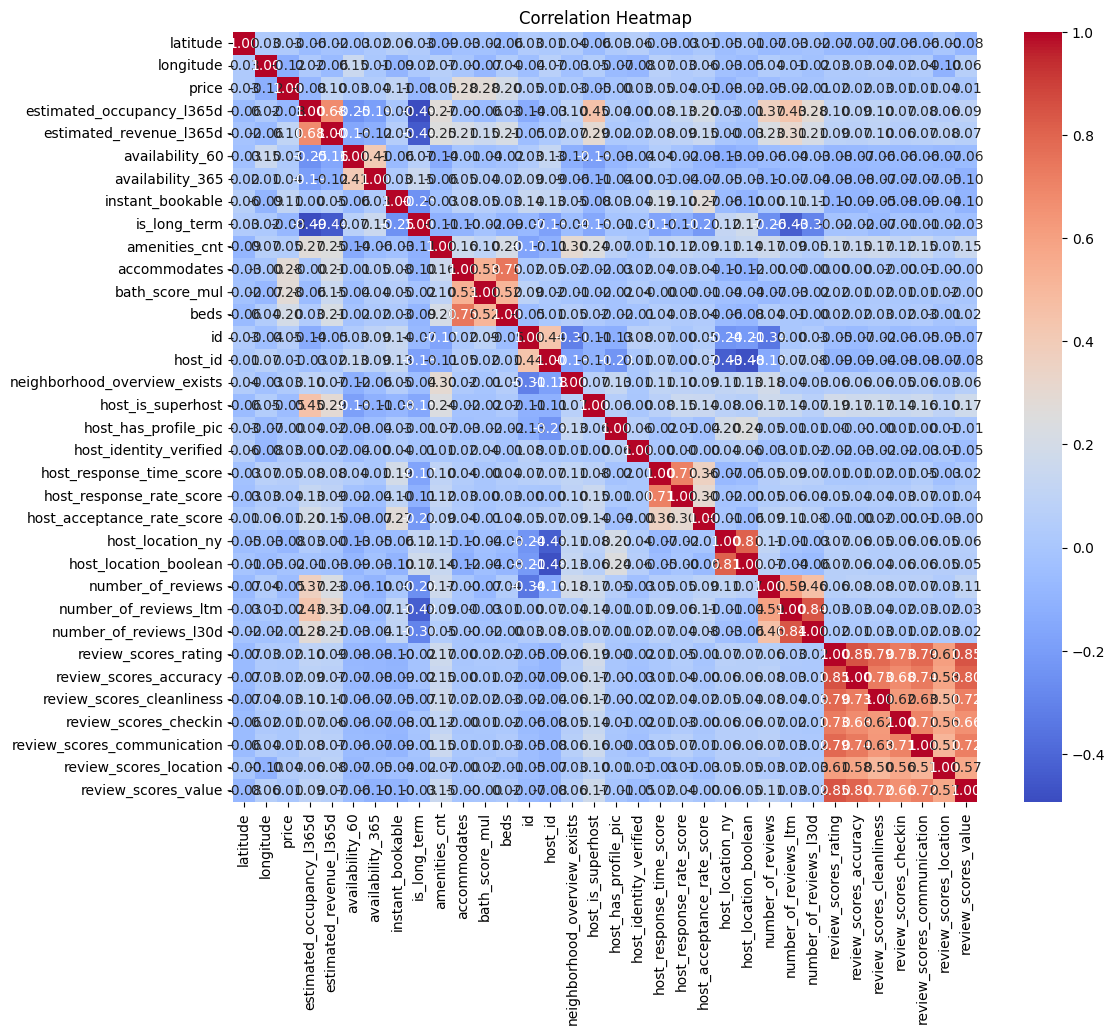

In [6]:
numeric_cols = df.select_dtypes(include='number')
plt.figure(figsize=(12,10))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
df.corr(numeric_only=True)
cor_matrix = df.corr(numeric_only=True)
revenue_corr = cor_matrix['estimated_revenue_l365d'].sort_values(ascending=False)
# 양의 상관관계 (0.3~0.8)
revenue_corr.head(15)
#음의 상관관계 
revenue_corr.tail(15)

cor_matrix = df.corr(numeric_only=True)
superhost_corr = cor_matrix['host_is_superhost'].sort_values(ascending=False)
# 양의 상관관계 (0.3~0.8)
superhost_corr.head(15)
superhost_corr.tail(15)

,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,is_long_term,amenities_cnt,...,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
latitude,1.000000,0.028745,0.030858,-0.056859,-0.020212,-0.031486,0.016790,0.064895,0.032669,-0.085415,...,-0.065638,-0.033973,-0.016841,-0.066883,-0.067053,-0.070430,-0.060393,-0.058273,-0.002207,-0.082837
longitude,0.028745,1.000000,-0.121305,0.021922,-0.063391,0.148630,0.013017,-0.092501,0.017503,0.065829,...,0.039486,0.009483,-0.021329,0.026788,0.026766,0.040344,0.023992,0.041077,-0.104146,0.064642
price,0.030858,-0.121305,1.000000,-0.082314,0.101971,0.031203,0.038117,0.108547,-0.078711,0.048263,...,-0.051742,-0.020382,-0.013426,0.019383,0.015364,0.025714,0.009886,0.010310,0.039129,0.005237
estimated_occupancy_l365d,-0.056859,0.021922,-0.082314,1.000000,0.677351,-0.246418,-0.193781,0.001554,-0.493351,0.272484,...,0.365630,0.430697,0.282812,0.099211,0.089942,0.102585,0.073658,0.082474,0.058204,0.091896
estimated_revenue_l365d,-0.020212,-0.063391,0.101971,0.677351,1.000000,-0.158936,-0.121961,0.049926,-0.442912,0.252820,...,0.228049,0.314473,0.208062,0.089810,0.073733,0.100114,0.057299,0.066747,0.084397,0.066596
availability_60,-0.031486,0.148630,0.031203,-0.246418,-0.158936,1.000000,0.409922,-0.064191,0.069350,-0.138370,...,-0.055645,-0.041669,-0.027744,-0.075766,-0.073150,-0.056757,-0.063554,-0.056942,-0.071834,-0.060588
availability_365,0.016790,0.013017,0.038117,-0.193781,-0.121961,0.409922,1.000000,0.031008,0.150304,-0.059346,...,-0.099922,-0.066977,-0.039197,-0.082101,-0.082327,-0.066713,-0.070348,-0.065840,-0.054455,-0.102597
instant_bookable,0.064895,-0.092501,0.108547,0.001554,0.049926,-0.064191,0.031008,1.000000,-0.248255,-0.028116,...,0.004129,0.111342,0.105028,-0.099255,-0.094253,-0.052176,-0.081107,-0.089964,-0.035598,-0.098985
is_long_term,0.032669,0.017503,-0.078711,-0.493351,-0.442912,0.069350,0.150304,-0.248255,1.000000,-0.112478,...,-0.257437,-0.431562,-0.298983,-0.020127,-0.016858,-0.067058,-0.006564,-0.012720,-0.021908,-0.034185
amenities_cnt,-0.085415,0.065829,0.048263,0.272484,0.252820,-0.138370,-0.059346,-0.028116,-0.112478,1.000000,...,0.169703,0.086831,0.047872,0.165482,0.146535,0.169467,0.118014,0.153222,0.069182,0.154028


예약률이 높은 숙소
예약률? number_of_reviews_l12m / 365 -> 12개월 리뷰수 365일로 나누면 하루당리뷰 
estimated_occupancy_l365d/availability_365 예약일수/예약가능일수?

In [12]:
df['reservation_rate'] = df['estimated_occupancy_l365d'] / df['availability_365']
df['reservation_rate'].round(2)

0         0.00
1         0.00
2         0.00
3        10.20
4         4.05
         ...  
22303     0.00
22304     0.00
22305     0.00
22306     0.00
22307     0.00
Name: reservation_rate, Length: 22308, dtype: float64

In [13]:
cor_matrix = df.corr(numeric_only=True)
occupancy_corr = cor_matrix['estimated_occupancy_l365d'].sort_values(ascending=False)
# 양의 상관관계 (0.3~0.8)
occupancy_corr.head(15)

estimated_occupancy_l365d       1.000000
estimated_revenue_l365d         0.677351
host_is_superhost               0.447693
number_of_reviews_ltm           0.430697
number_of_reviews               0.365630
number_of_reviews_l30d          0.282812
amenities_cnt                   0.272484
host_acceptance_rate_score      0.199341
reservation_rate                0.197212
host_response_rate_score        0.130396
review_scores_cleanliness       0.102585
review_scores_rating            0.099211
neighborhood_overview_exists    0.096510
review_scores_value             0.091896
review_scores_accuracy          0.089942
Name: estimated_occupancy_l365d, dtype: float64

availability_30/60/90/365 

예약가능여부가 예약으로 인한 불가인지 호스트가 의도적으로 막아둔 것으로 인한 불가인지 모호